Uses a prompted BERT to learn a metric between passage and query with the goal of solving the passage retrieval task in MS MARCO https://microsoft.github.io/msmarco/

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertModel, BertTokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data Exploration
The dataset is massive, near 26GB. Note we use the triples version of the dataset, designed to be convenient for training, which provides triples of the form (query, relevant passage, non relevant passage)

In [2]:
df = pd.read_csv('Datasets/triples.train.small.tsv', sep='\t', nrows=10000, # only read a small sample of the data for now 
                 names=["query", "positive", "negative"], encoding="utf-8") 
df

,query,positive,negative
0,is a little caffeine ok during pregnancy,We donât know a lot about the effects of caf...,It is generally safe for pregnant women to eat...
1,what fruit is native to australia,Passiflora herbertiana. A rare passion fruit n...,"The kola nut is the fruit of the kola tree, a ..."
2,how large is the canadian military,The Canadian Armed Forces. 1 The first large-...,The Canadian Physician Health Institute (CPHI)...
3,types of fruit trees,Cherry. Cherry trees are found throughout the ...,"The kola nut is the fruit of the kola tree, a ..."
4,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,...","However, you still need some niacin each day; ..."
...,...,...,...
9995,what does petsmart pay part time,Petsmart-About $7 (for a grooming bather or ca...,What is double-time pay? Double-time pay is a ...
9996,what does dystopian mean,Top definition. dystopian. A dystopia (alterna...,(film) Equilibrium is a 2002 American dystopia...
9997,when is a partnership return due,1 Partnership and S Corporation tax returns wi...,"â¢ With decreased stroke volume, due to decre..."
9998,what type of cable is used between switches ?,No thats not possible. Only if you have auto-m...,"1-16 of 1,177 results for verizon network type..."


In [3]:
df.iloc[0]["positive"]

'We donâ\x80\x99t know a lot about the effects of caffeine during pregnancy on you and your baby. So itâ\x80\x99s best to limit the amount you get each day. If youâ\x80\x99re pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1Â½ 8-ounce cups of coffee or one 12-ounce cup of coffee.'

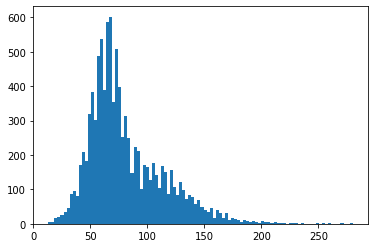

In [4]:
# plot a passage length histogram
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
lengths = df["positive"].apply(lambda x: len(tokenizer.encode(x)))
plt.hist(lengths, bins=100)
plt.show()

In [5]:
max_length=256 # from the plot we can see a batch size of 256 is more than enough to represent most passages

In [6]:
# Create a train test split by first creating a dataset with query, sample and label. Then splitting it
positive = df[["query", "positive"]].rename(columns={"positive": "passage"})
positive["label"] = 1
negative = df[["query", "negative"]].rename(columns={"negative": "passage"})
negative["label"] = 0
dataset = pd.concat([positive, negative], axis=0).reset_index(drop=True)
dataset = dataset.sample(20000, replace=False)
X_train, X_test, y_train, y_test = train_test_split(dataset[["query", "passage"]], np.array(dataset["label"]), test_size=0.2)

In [7]:
X_train

,query,passage
13877,iterator value for an empty list,Turns out I can get a loose leaf visa for Viet...
13186,steelers who died of cte,"In fact, seven NFL teams have no cheerleaders ..."
1586,who starred in play misty for me,"Play Misty For Me (1971), Clint Eastwood's fir..."
10849,spirit animal butterfly meaning,Freedom is the most sacred and spiritual meani...
685,new york mammal is called,"Bounding is one typeof jumping. Rabbits, squir..."
...,...,...
18143,hipster synonym,Synonym(s): tegument (2) 1 Synonym(s): integu...
6549,where does the mississippi river run.,"The Mississippi River is 3,000 miles long and ..."
14412,what is a resting tremor,For most people a resting heart rate of 57 is ...
5770,what is considered domestic violence,"Any abusive, violent, coercive, forceful, or t..."


# Modelling
Define the dataset class and a BERT_prompt class, with prompting logic in the dataset for speed

In [8]:
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
tokenizer.encode("Hello " + tokenizer.mask_token)

[101, 7592, 103, 102]

In [10]:
# Define a dataset class for prompted BERT fine tuning
# The dataset takes in query and passage, and then construct a training sample as: <query> + <prompt> + [MASK] + <passage>, returning the position of the mask
# It also performs padding and stores the labels
class BERTPromptDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, labels, tokenizer, prompt="Is the following text relevant?", max_length=max_length):
        # Construct the input sentence
        input_sentences = ["{}. {} {} {}".format(query, prompt, tokenizer.mask_token, passage) for _, (query, passage) in dataset.iterrows()]
        
        # Encode and store
        encodings_dict = tokenizer.batch_encode_plus(input_sentences, truncation=True, max_length=max_length, padding="max_length")
        self.input_ids = encodings_dict['input_ids']
        self.attn_masks = encodings_dict['attention_mask']
        self.labels = labels

        # Calculate the position of the mask using self.input_ids
        mask_id = tokenizer.encode(tokenizer.mask_token)[1] # 103
        self.mask_pos = [sent_ids.index(mask_id) for sent_ids in self.input_ids]
        
        
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return_dict = {"input_ids": torch.tensor(self.input_ids[idx]),
                       "attention_mask": torch.tensor(self.attn_masks[idx]), 
                       "mask_pos": torch.tensor(self.mask_pos[idx]),
                       "labels": torch.tensor(self.input_ids[idx])} 
        return return_dict

In [11]:
dataset = BERTPromptDataset(X_train, y_train, tokenizer)
dataset[0:10]

{'input_ids': tensor([[  101,  2009,  6906,  ...,     0,     0,     0],
         [  101, 15280,  2040,  ...,     0,     0,     0],
         [  101,  2040,  5652,  ...,     0,     0,     0],
         ...,
         [  101,  3465,  2000,  ...,     0,     0,     0],
         [  101,  2054,  2106,  ...,     0,     0,     0],
         [  101,  2129,  2020,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'mask_pos': tensor([16, 14, 15, 12, 13, 20, 13, 13, 17, 15]),
 'labels': tensor([[  101,  2009,  6906,  ...,     0,     0,     0],
         [  101, 15280,  2040,  ...,     0,     0,     0],
         [  101,  2040,  5652,  ...,     0,     0,     0],
         ...,
         [  101,  3465,  2000,  ...,     0,     0,     0],
         [  101,  2054,  2106,  ...,     0,     0,

In [37]:
# Class that expects a prompted input from the BERTPromptDataset
# Takes the input, forward propagates it through BERT and concatenates the output at the [MASK] and [CLS] token to get a representation of the text
# This is then passed to a linear head to perform binary classification for how relevant it is
class BERTPrompt(torch.nn.Module):
    def __init__(self, bert, tokenizer):
        super().__init__()
        self.bert = bert.cuda()
        self.tokenizer = tokenizer
        self.linear = torch.nn.Linear(768*2, 1).cuda()
        
    # input_dict is obtained through indexing the dataset e.g. dataset[0:10]
    def forward(self, input_dict):
        output = self.bert(input_dict["input_ids"].cuda(), attention_mask=input_dict['attention_mask'].cuda())[0] # output is of shape [10, 256, 768]
        cls_out = output[:, 0, :]
        mask_out = output[torch.arange(cls_out.shape[0]).cuda(), input_dict["mask_pos"].cuda(), :] # indexing like [[0, 1], [13, 14]] will select items [[0, 13], [1, 14]]
        
        representation = torch.cat([cls_out, mask_out], dim=1)
        logit = self.linear(representation)
        return logit

In [38]:
bert_prompt = BERTPrompt(bert, tokenizer)

In [39]:
with torch.no_grad():
    output = bert_prompt.forward(dataset[:10])
output

tensor([[-0.4518],
        [-0.1630],
        [-0.1928],
        [-0.2144],
        [ 0.1710],
        [-0.0614],
        [-0.2812],
        [ 0.0138],
        [-0.2803],
        [-0.3146]], device='cuda:0')